# Session 2 - Notebook 1: Financial Data Analysis

Before building portfolios, we first need to understand how different real-world investments behave.

We will compare:

- Individual well-known companies
- Defensive vs growth businesses
- Bonds and gold as stabilisers

All measured against the S&P 500 index, which represents the overall US stock market.

This helps answer:

- Which assets are riskier than the market?
- Which move with the market?
- Which help diversify risk?

---

## Downloading Historical Close Price Data

Example of selected investments to analyse:   

1. Market benchmark  
   - ^GSPC (S&P 500)  

2. Growth / Tech
   - AAPL (Apple)  
   - MSFT (Microsoft)  
   - AMZN (Amazon)  

3. Defensive equity (stable consumer demand)
   - KO (Coca-Cola)  

4. Cyclical / macro-sensitive equity (i.e., moves with oil prices, inflation cycles, global demand)

   - XOM (Exxon Mobil)  

5. Diversifiers
   - TLT (US Treasury bonds)  
   - GLD (Gold)  


This mirrors how real investors think when constructing diversified portfolios.


In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [21]:
# Market benchmark (S&P 500)
market = "^GSPC"

# Common real-world investments
tickers = [
    "^GSPC",   # S&P 500 (market)
    "GOOGL",   # Google
    "MSFT",    # Microsoft
    "AMZN",    # Amazon
    "ORCL",    # Oracle
    "KO",      # Coca-Cola
    "PEP",      # Coca-Cola
    "UPS",     # UPS
    "TLT",     # US Treasury Bonds ETF
    "GLD",      # Gold ETF
    "QS"
]

# Start and end date of data
start_date = "2012-01-01"
end_date = None

# Download price data: Close Price
# auto_adjust automatically converts price into adjusted price
prices = yf.download(tickers, start=start_date, end = end_date, auto_adjust=True, progress=False)["Close"]
prices = prices.dropna()

# Daily returns
returns = prices.pct_change().dropna()


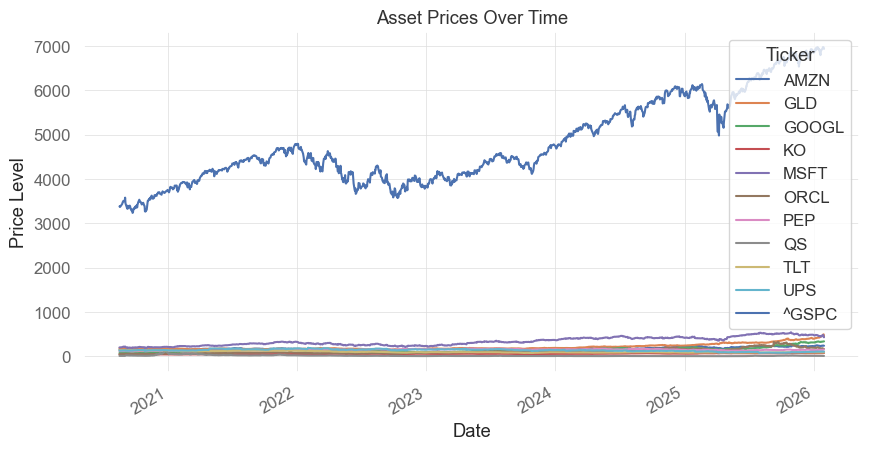

In [22]:
prices.plot(figsize=(10,5), title="Asset Prices Over Time")
plt.ylabel("Price Level")
plt.show()

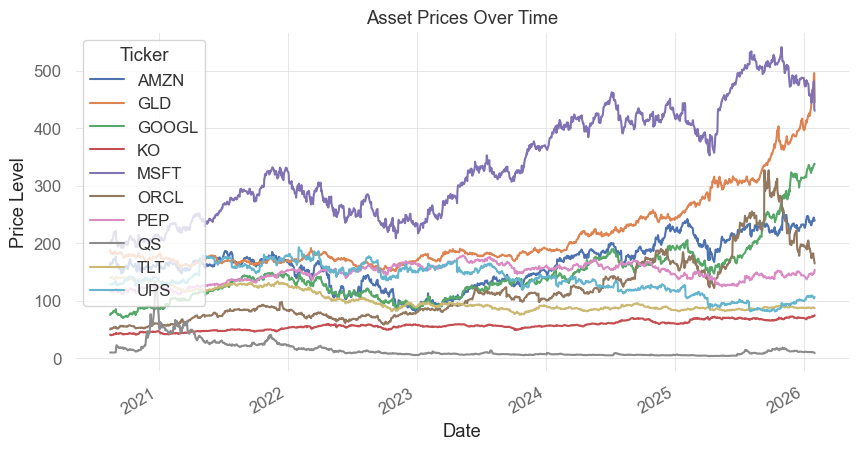

In [23]:
# Exclude S&P 500 from price plot
asset_only = prices.drop(columns=[market])

asset_only.plot(figsize=(10,5), title="Asset Prices Over Time")
plt.ylabel("Price Level")
plt.show()

## Part 1 - Asset Behaviour Metrics (Annualised)

To compare different investments fairly, we convert daily market movements into annualised financial metrics.

This allows us to measure:

- Long-term return potential  
- Risk (volatility)  
- Risk-adjusted performance (Sharpe)  
- Worst historical loss (drawdown)  

These are the core quantities used in portfolio analysis.


1. **Annualised Return (using daily returns)**

$
R_{\text{annual}} = \left( \prod_{t=1}^{n} (1 + r_t) \right)^{\frac{252}{n}} - 1
$


where:

- $r_t$ = daily return at time t  
- $n$ = total number of trading days  
- $252$ = average trading days per year  

Explanation:

This compounds all daily returns to get total growth, then scales it to an annual basis. It represents the yearly growth rate assuming returns compound continuously over time.


In [24]:
def annual_return(r):
    return (1 + r).prod() ** (252 / len(r)) - 1

2. **Annualised Volatility (using daily returns)**

$
\sigma_{\text{annual}} = \sigma_{\text{daily}} \times \sqrt{252}
$

where:

- $\sigma_{\text{daily}}$ = standard deviation of daily returns
- $252$ = average trading days per year

Explanation:

This scales daily return variability to a yearly level. It measures how much an asset’s returns typically fluctuate over a year and is used as the standard proxy for financial risk.

In [25]:
def annual_volatility(r):
    return r.std() * np.sqrt(252)

3. **Sharpe Ratio (risk-adjusted return)**

$
\text{Sharpe} = \frac{R_{\text{annual}} - R_f}{\sigma_{\text{annual}}}
$

where:
- $R_{\text{annual}}$ = annualised return of the asset
- $R_f$ = risk-free rate (often approximated as 0)
- $\sigma_{\text{annual}}$ = annualised volatility

Explanation:

This measures how much return is earned per unit of risk. A higher Sharpe ratio indicates better risk-adjusted performance.

4. **Maximum Drawdown**

<p align="center">
<img src="https://i0.wp.com/blogs.cfainstitute.org/investor/files/2014/08/MSCI-EM-Total-Return.png?ssl=1" width="500">
</p>

*Reference:* https://blogs.cfainstitute.org/investor/2013/02/12/sculpting-investment-portfolios-maximum-drawdown-and-optimal-portfolio-strategy/


$
\text{DD}{\max} = \min_t \left( \frac{P_t}{\max{s \le t} P_s} - 1 \right)
$

where:
- $P_t$ = asset price at time $t$
- $\max_{s \le t} P_s$ = highest price reached up to time $t$

Explanation:

This measures the worst percentage loss from a historical peak to a subsequent trough. It captures the maximum pain an investor would have experienced before a recovery.

In [26]:
def max_drawdown(price_series):
    peak = price_series.cummax()
    return (price_series / peak - 1).min()

In [27]:
summary = pd.DataFrame(index=tickers)

summary["Annual Return"] = [annual_return(returns[t]) for t in tickers]
summary["Annual Volatility"] = [annual_volatility(returns[t]) for t in tickers]
summary["Sharpe (rf=0)"] = summary["Annual Return"] / summary["Annual Volatility"]
summary["Max Drawdown"] = [max_drawdown(prices[t]) for t in tickers]

summary.sort_values("Annual Return", ascending=False)


,Annual Return,Annual Volatility,Sharpe (rf=0),Max Drawdown
GOOGL,0.318294,0.308725,1.030997,-0.443200
ORCL,0.244901,0.379207,0.645826,-0.496539
GLD,0.173444,0.165192,1.049953,-0.210328
MSFT,0.150536,0.263462,0.571377,-0.371485
^GSPC,0.141335,0.169456,0.834048,-0.254251
KO,0.117852,0.164913,0.714632,-0.172748
AMZN,0.077947,0.350255,0.222544,-0.561453
PEP,0.052146,0.178985,0.291341,-0.303227
QS,-0.020412,1.078362,-0.018929,-0.973646
UPS,-0.034821,0.279803,-0.124449,-0.579177


In practice, financial analysts often use specialised libraries such as `quantstats` to compute performance metrics directly, as it is faster and less error-prone. However, we first implemented the formulas manually to understand the mathematics behind return, risk, drawdowns, and risk-adjusted performance. This builds strong financial intuition, which is essential when interpreting models and constructing portfolios rather than treating metrics as black boxes.

In [28]:
pip install quantstats

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
import quantstats as qs

summary_qs = pd.DataFrame({
    "Annual Return": qs.stats.cagr(returns),
    "Annual Volatility": qs.stats.volatility(returns),
    "Sharpe": qs.stats.sharpe(returns),
    "Max Drawdown": qs.stats.max_drawdown(returns)
}).sort_values("Annual Return", ascending=False)
summary_qs

,Annual Return,Annual Volatility,Sharpe,Max Drawdown
Ticker,,,,
GOOGL,0.318294,0.308725,1.049647,-0.443200
ORCL,0.244901,0.379207,0.761252,-0.496539
GLD,0.173444,0.165192,1.051598,-0.210328
MSFT,0.150536,0.263462,0.664105,-0.371485
^GSPC,0.141335,0.169456,0.864962,-0.254251
KO,0.117852,0.164913,0.758158,-0.172748
AMZN,0.077947,0.350255,0.389187,-0.561453
PEP,0.052146,0.178985,0.373492,-0.303227
QS,-0.020412,1.078362,0.472492,-0.973646


---

## Part 2 - Market Relationships

After understanding each asset’s standalone return and risk, we now examine how each investment behaves relative to the overall market. Using the S&P 500 as our benchmark, we analyse:

- Beta — how strongly an asset responds to market movements
- Correlation — how closely it moves in the same direction as the market
- Alpha — whether it outperforms or underperforms the market after adjusting for risk

This helps identify:
1. high-risk market amplifiers
2. defensive or low-sensitivity assets
3. true diversification candidates
4. assets that genuinely add excess return

These relationships form the foundation of portfolio construction and optimisation.

1. **Beta (Market sensitivity)**

<p align="center">
<img src="https://a.storyblok.com/f/179899/3360x1760/516d5df4ba/graph-2.png" width="500">
</p>

*Reference:* https://www.trading212.com/learn/investing-101/alpha-vs-beta-stocks


$
\beta = \frac{\text{Cov}(r_{\text{asset}}, r_{\text{market}})}{\text{Var}(r_{\text{market}})}
$

where:
- $r_{\text{asset}}$ = asset daily returns
- $r_{\text{market}}$ = market (S&P 500) daily returns
- $\text{Cov}(\cdot)$ = covariance between asset and market
- $\text{Var}(\cdot)$ = variance of market returns

Explanation:

Beta shows the volatility of an individual stock compared to the systematic risk of the entire market.

- A beta above 1 means a stock is more volatile than the overall market
- A beta below 1 means a stock is less volatile than the overall market
- A beta less than 0 means the stock is losing money while the market as a whole is gaining

2. **Correlation (directional relationship)**

$
\rho = \frac{\text{Cov}(r_{\text{asset}}, r_{\text{market}})}{\sigma_{\text{asset}} \sigma_{\text{market}}}
$

where:
- $\sigma_{\text{asset}}$ = standard deviation of asset returns
- $\sigma_{\text{market}}$ = standard deviation of market returns

Explanation:

Correlation measures how closely an asset moves in the same direction as the market, ranging from −1 to +1. Lower correlation indicates better diversification potential.

In [30]:
market_returns = returns[market]

def beta(asset_returns, market_returns):
    return np.cov(asset_returns, market_returns)[0, 1] / np.var(market_returns)

# Beta
summary["Beta vs Market"] = [
    beta(returns[t], market_returns) for t in tickers
]

# Correlation
summary["Correlation vs Market"] = [
    returns[t].corr(market_returns) for t in tickers
]

summary.sort_values("Beta vs Market", ascending=False)


,Annual Return,Annual Volatility,Sharpe (rf=0),Max Drawdown,Beta vs Market,Correlation vs Market
QS,-0.020412,1.078362,-0.018929,-0.973646,1.869113,0.293502
AMZN,0.077947,0.350255,0.222544,-0.561453,1.476350,0.713749
GOOGL,0.318294,0.308725,1.030997,-0.443200,1.268300,0.695651
MSFT,0.150536,0.263462,0.571377,-0.371485,1.168110,0.750770
ORCL,0.244901,0.379207,0.645826,-0.496539,1.079350,0.481978
^GSPC,0.141335,0.169456,0.834048,-0.254251,1.000730,1.000000
UPS,-0.034821,0.279803,-0.124449,-0.579177,0.851284,0.515185
PEP,0.052146,0.178985,0.291341,-0.303227,0.364569,0.344909
KO,0.117852,0.164913,0.714632,-0.172748,0.354196,0.363689
GLD,0.173444,0.165192,1.049953,-0.210328,0.124606,0.127729


3. **Alpha(risk-adjusted excess performance)**

$
\alpha = R_{\text{asset}} - \left[ R_f + \beta (R_{\text{market}} - R_f) \right]
$

where:
- $R_{\text{asset}}$ = asset annualised return
- $R_{\text{market}}$ = market annualised return
- $R_f$ = risk-free rate (often set to 0 for simplicity)
- $\beta$ = asset beta

Explanation:

Alpha measures how much an asset outperformed or underperformed the market after accounting for its risk exposure. A positive alpha indicates true excess performance, while a negative alpha indicates underperformance.

Therefore, when $R_f = 0$, $ \alpha$ can be approximated as:

$
\alpha \approx R_{\text{asset}} - \beta R_{\text{market}}
$

In [31]:
# Alpha (risk-free rate assumed 0 for simplicity)
market_annual_return = annual_return(market_returns)

summary["Alpha"] = [
    annual_return(returns[t]) - summary.loc[t, "Beta vs Market"] * market_annual_return
    for t in tickers
]

summary.sort_values("Beta vs Market", ascending=False)

,Annual Return,Annual Volatility,Sharpe (rf=0),Max Drawdown,Beta vs Market,Correlation vs Market,Alpha
QS,-0.020412,1.078362,-0.018929,-0.973646,1.869113,0.293502,-0.284582
AMZN,0.077947,0.350255,0.222544,-0.561453,1.476350,0.713749,-0.130712
GOOGL,0.318294,0.308725,1.030997,-0.443200,1.268300,0.695651,0.139039
MSFT,0.150536,0.263462,0.571377,-0.371485,1.168110,0.750770,-0.014559
ORCL,0.244901,0.379207,0.645826,-0.496539,1.079350,0.481978,0.092352
^GSPC,0.141335,0.169456,0.834048,-0.254251,1.000730,1.000000,-0.000103
UPS,-0.034821,0.279803,-0.124449,-0.579177,0.851284,0.515185,-0.155137
PEP,0.052146,0.178985,0.291341,-0.303227,0.364569,0.344909,0.000619
KO,0.117852,0.164913,0.714632,-0.172748,0.354196,0.363689,0.067792
GLD,0.173444,0.165192,1.049953,-0.210328,0.124606,0.127729,0.155833


#### Key observations from the asset behaviour summary

- Tech stocks (AAPL, MSFT, AMZN) show higher returns with high beta, meaning they amplify market movements

- Gold (GLD) has low beta and near-zero correlation, yet strong Sharpe and positive alpha → strong diversifier

- Coca-Cola (KO) behaves defensively with low beta, moderate returns, and lower volatility  

- Bonds (TLT) exhibit negative beta and correlation, but weak recent performance

- The S&P 500 behaves as expected — beta ≈ 1, correlation ≈ 1, alpha ≈ 0

- Higher return generally comes with larger drawdowns


---

## Part 3 - Visualising Asset Behaviour & Market Relationships

While summary tables provide precise metrics, visualisations allow us to quickly identify patterns, trade-offs, and diversification opportunities. In this section, we transform the numerical performance and risk measures into intuitive plots to better understand how assets compare in terms of return, volatility, market exposure, and risk-adjusted performance.

1. **Normalised price comparison**

Assets have very different price levels (for example, Apple trades at hundreds of dollars while the S&P 500 is in the thousands). To compare growth fairly, we rescale all price series to start at the same value.

Normalising removes price scale and keeps growth comparison only. Thus, this shows stock that *grew faster*, not which was more expensive.

- Steeper lines → faster long-term growth
- Flatter lines → slower or defensive assets
- Diverging paths → differences in risk and return


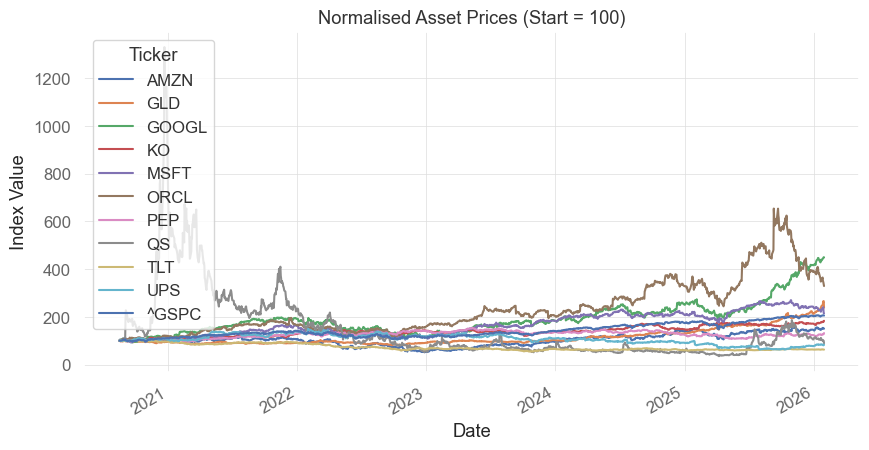

In [32]:
norm_px = prices / prices.iloc[0] * 100

norm_px.plot(figsize=(10,5), title="Normalised Asset Prices (Start = 100)")
plt.ylabel("Index Value")
plt.show()



Key observation for relative growth over time:

- Technology stocks (AAPL, MSFT, AMZN) significantly outperformed the overall market, showing much stronger long-term growth but with noticeable volatility
- The S&P 500 delivered steady, moderate growth, acting as a smooth market benchmark
- Gold (GLD) showed strong performance with low market sensitivity, reinforcing its role as a diversification hedge
- Coca-Cola (KO) grew slowly but steadily, reflecting its defensive nature
- Energy (XOM) experienced large cycles, strong rebounds after downturns but weaker long-term consistency
- Bonds (TLT) underperformed during this period, particularly as interest rates rose

2. **Daily Return Distributions**

Daily return distributions show how prices usually move each day and how extreme those moves can get. Wide shapes mean higher risk and big swings, while narrow shapes mean more stable assets. They also reveal crash-like losses that volatility alone does not fully capture.

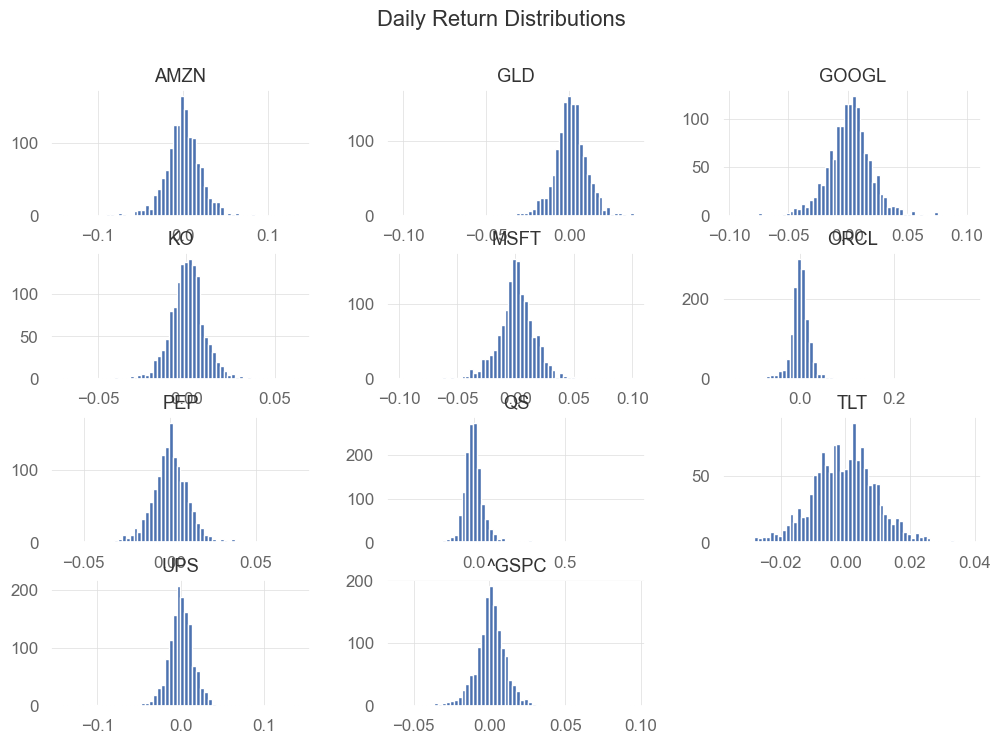

In [33]:
returns.hist(bins=60, figsize=(12,8))
plt.suptitle("Daily Return Distributions")
plt.show()

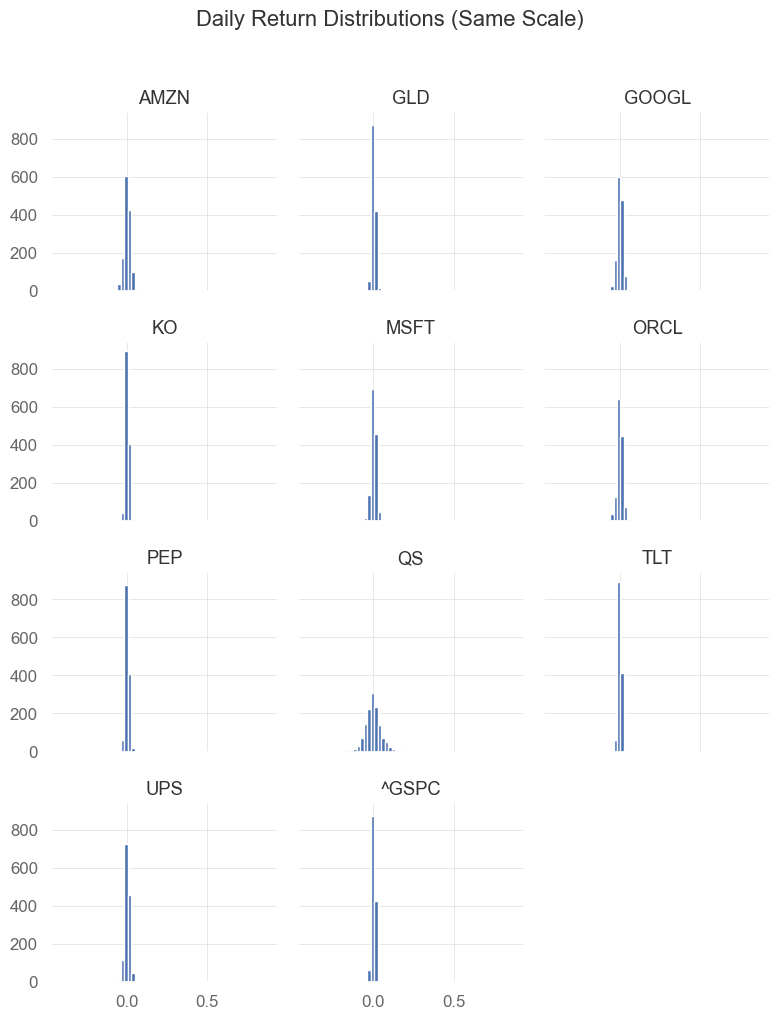

In [34]:
cols = returns.columns

# Common x-axis range
xmin = returns.min().min()
xmax = returns.max().max()
bins = np.linspace(xmin, xmax, 60)

n = len(cols)
n_cols = 3
n_rows = int(np.ceil(n / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 2.5 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, asset in enumerate(cols):
    axes[i].hist(returns[asset], bins=bins)
    axes[i].set_title(asset)

# Remove empty subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Daily Return Distributions (Same Scale)", y=1.02)
plt.tight_layout()
plt.show()


Observations:

- Technology stocks (AAPL, MSFT, AMZN) show wider spreads, indicating higher volatility and larger daily swings
- Diversified assets (KO, GLD, TLT) have narrower distributions, reflecting more stable daily movements
- All assets exhibit fat tails, meaning extreme gains and losses occur more often than a normal distribution would suggest

3. **Alpha & Beta Return**

Rearranging the alpha definition to express total return:

$
R_{\text{asset}} \approx \beta R_{\text{market}} + \alpha
$

This shows that:
- Total asset return = market-driven return + alpha (excess performance)
- Which is exactly what is visualised in the stacked bar chart: the bottom segment is $\beta R_{\text{market}}$ and the top segment is $\alpha$
together they sum to $R_{\text{asset}}$

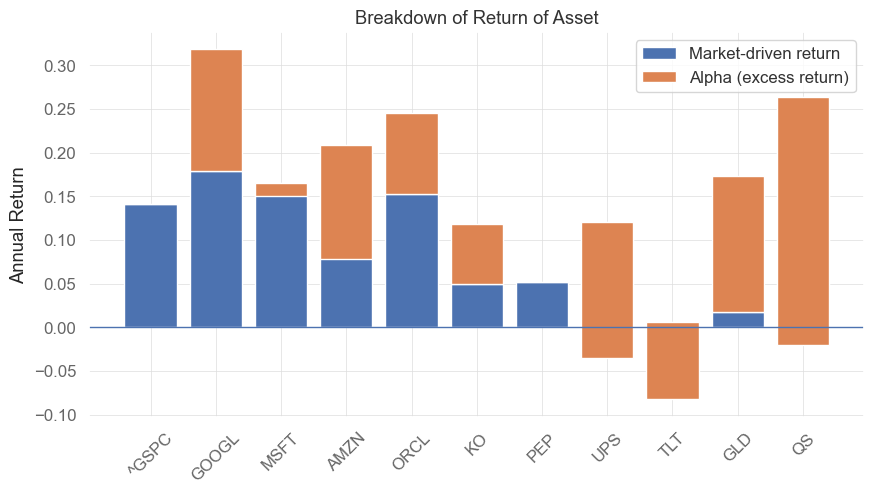

In [35]:
assets = summary.index
market_return = summary.loc["^GSPC", "Annual Return"]

beta_component = summary["Beta vs Market"] * market_return
alpha_component = summary["Alpha"]

plt.figure(figsize=(10,5))

plt.bar(assets, beta_component, label="Market-driven return")
plt.bar(assets, alpha_component, bottom=beta_component, label="Alpha (excess return)")

plt.axhline(0, linewidth=1)
plt.ylabel("Annual Return")
plt.title("Breakdown of Return of Asset")
plt.legend()
plt.xticks(rotation=45)
plt.show()


Observations:

- Growth stocks (AAPL, MSFT, AMZN) earned strong returns largely from market exposure, but also generated meaningful positive alpha, indicating true outperformance
- The market benchmark (^GSPC) shows almost all return coming purely from market movement, as expected
- Defensive and cyclical stocks (KO, XOM) produced most of their returns through market exposure with limited alpha contribution
- Gold (GLD) delivered a large portion of its return through alpha with very low market dependence, highlighting strong diversification benefits
- Bonds (TLT) showed negative market-driven return and near-zero alpha, reflecting weak recent performance and defensive behaviour

---

# Part 4

2. **Risk–Return Map**

The risk–return map summarises each asset into a single point using:

1. Annualised return → how fast the asset grew per year (CAGR-style)
2. Annualised volatility → how much the asset fluctuates (risk)

This makes it easy to compare assets side-by-side and identify which ones offer strong returns for the amount of risk taken.


<p align="center">
<img src="https://www.extension.iastate.edu/agdm/wholefarm/html/images/c5-214fig1.gif" width="300">
</p>

*Reference:* https://www.extension.iastate.edu/agdm/wholefarm/html/c5-214.html


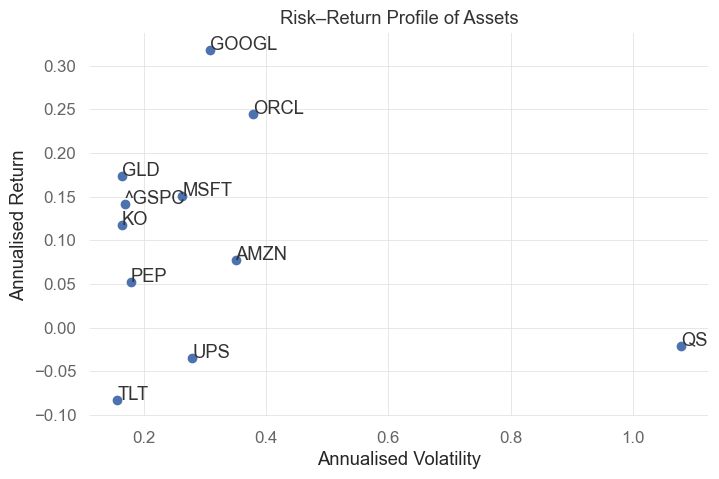

In [36]:
plt.figure(figsize=(8,5))
plt.scatter(summary["Annual Volatility"], summary["Annual Return"])

for t in summary.index:
    plt.annotate(t, (summary.loc[t,"Annual Volatility"], summary.loc[t,"Annual Return"]))

plt.xlabel("Annualised Volatility")
plt.ylabel("Annualised Return")
plt.title("Risk–Return Profile of Assets")
plt.show()


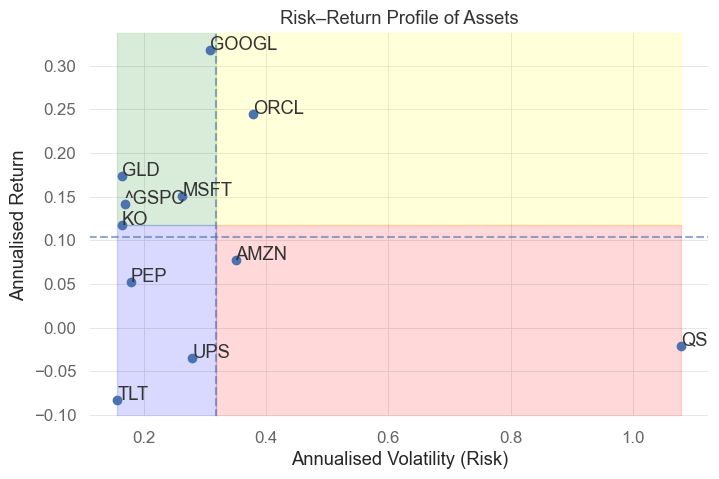

In [37]:
x = summary["Annual Volatility"]
y = summary["Annual Return"]

x_mid = x.mean()
y_mid = y.mean()

plt.figure(figsize=(8,5))

# Background regions
plt.axvspan(x.min(), x_mid, ymin=0.5, ymax=1, alpha=0.15, color="green")   # low risk, high return
plt.axvspan(x_mid, x.max(), ymin=0.5, ymax=1, alpha=0.15, color="yellow")  # high risk, high return
plt.axvspan(x.min(), x_mid, ymin=0, ymax=0.5, alpha=0.15, color="blue")    # low risk, low return
plt.axvspan(x_mid, x.max(), ymin=0, ymax=0.5, alpha=0.15, color="red")     # high risk, low return

# Scatter points
plt.scatter(x, y, zorder=3)

for t in summary.index:
    plt.annotate(t, (x[t], y[t]))

# Mid reference lines
plt.axvline(x_mid, linestyle="--", alpha=0.6)
plt.axhline(y_mid, linestyle="--", alpha=0.6)

plt.xlabel("Annualised Volatility (Risk)")
plt.ylabel("Annualised Return")
plt.title("Risk–Return Profile of Assets")
plt.show()


In [39]:
asset = "AAPL"

price_series = prices[asset]


KeyError: 'AAPL'

In [ ]:
horizon = 252   # ~1 trading year

multiples = (price_series.shift(-horizon) / price_series).dropna()
multiples.head()


,AAPL
Date,
2018-01-02,0.837830
2018-01-03,0.873749
2018-01-04,0.867774
2018-01-05,0.874361
2018-01-08,0.892524


In [40]:
bins = [-np.inf, 0.8, 0.95, 1.05, 1.3, np.inf]
labels = ["<0.8", "0.8–0.95", "0.95–1.05", "1.05–1.3", ">1.3"]

bucket = pd.cut(multiples, bins=bins, labels=labels)

probabilities = bucket.value_counts(normalize=True).sort_index()
scenario_multiples = multiples.groupby(bucket).median()

outcomes = pd.DataFrame({
    "Scenario": probabilities.index,
    "Multiple": scenario_multiples.values,
    "Probability": probabilities.values
})

outcomes


NameError: name 'multiples' is not defined

In [ ]:
expected_multiple = (outcomes["Multiple"] * outcomes["Probability"]).sum()

risk_of_loss = outcomes.loc[outcomes["Multiple"] < 1, "Probability"].sum()

expected_multiple, risk_of_loss

(np.float64(1.2768161533995803), np.float64(0.07363687464867903))

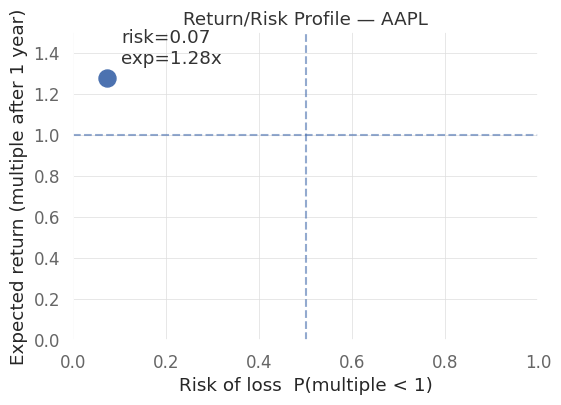

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter([risk_of_loss], [expected_multiple], s=150)

plt.axvline(0.5, linestyle="--", alpha=0.6)
plt.axhline(1.0, linestyle="--", alpha=0.6)

plt.xlim(0,1)
plt.ylim(0, max(1.5, expected_multiple + 0.2))

plt.xlabel("Risk of loss  P(multiple < 1)")
plt.ylabel("Expected return (multiple after 1 year)")
plt.title(f"Return/Risk Profile — {asset}")

plt.annotate(f"risk={risk_of_loss:.2f}\nexp={expected_multiple:.2f}x",
             (risk_of_loss, expected_multiple),
             textcoords="offset points", xytext=(10,10))

plt.show()


Rolling volatility — how risk changes over time

In [ ]:
rolling_vol = ret.rolling(63).std() * np.sqrt(252)

rolling_vol.plot(figsize=(10,5), title="Rolling 3-Month Annualised Volatility")
plt.ylabel("Volatility")
plt.show()


NameError: name 'ret' is not defined

Downside risk — VaR & CVaR

In [ ]:
def var_cvar(r, alpha=0.05):
    var = r.quantile(alpha)
    cvar = r[r <= var].mean()
    return var, cvar

downside = pd.DataFrame(index=tickers, columns=["VaR 5%","CVaR 5%"])

for t in tickers:
    downside.loc[t] = var_cvar(ret[t])

downside.sort_values("CVaR 5%")
